# Install dependencies

In [8]:
!pip install -qU langchain-community langgraph langchain-text-splitters langchain-anthropic langchain-openai tavily-python pypdf langgraph-checkpoint-sqlite

In [1]:
import os

from langchain import hub  

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import PyPDFLoader

from langchain_core.documents import Document
from langchain_core.messages import HumanMessage, SystemMessage, RemoveMessage, AIMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.vectorstores import InMemoryVectorStore

from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph, END
from langgraph.prebuilt import create_react_agent

from IPython.display import Image, display

from typing_extensions import List, TypedDict, Annotated, Literal

from dotenv import load_dotenv

from time import sleep

load_dotenv()

True

In [132]:
search = TavilySearchResults(max_results=2)
search_result = search.invoke("Who is current president of Indonesia?")
print(search_result)

tools = [search]

[{'url': 'https://www.abc.net.au/news/2024-10-20/prabowo-subianto-to-take-up-indonesian-presidency/104494762', 'content': "Former special forces commander Prabowo Subianto sworn in as Indonesian president - ABC News Prabowo Subianto was sworn in on Sunday as president of the world's third-largest democracy, Indonesia. abc.net.au/news/prabowo-subianto-to-take-up-indonesian-presidency/104494762 Indonesia's Prabowo Subianto has taken over as president of the world's third-largest democracy, months after sweeping the country's election with policies such as free meals for school children and with the outgoing leader's son as his running mate. Supporters outside the Presidential Palace watch a live feed showing Prabowo Subianto taking the oath as President of Indonesia at the parliament in Jakarta. Indonesia's election commission confirms Prabowo Subianto as the next president. A crowd of well-wishers gather outside the Presidential Palace as they wait for the inauguration of Indonesia's pr

In [32]:
llm = ChatOpenAI(
    model='gpt-3.5-turbo',
    temperature=0.5,
    max_retries=2,
    max_tokens=100
)

messages = [
    SystemMessage("Classify wether this text is Bahasa Indonesia or English"),
    HumanMessage("Hello, how are you? apakah kamu sehat?")
]

for token in llm.stream(messages):
    print(token.content, end='')
    sleep(0.1)

Page 0: Visi & Misi 
Visi 
Sumber inovasi yang universal di Bidang Ilmu Teknik Elektro & Teknologi Informasi, untuk 
kepentingan bangsa dan kemanusiaan, dijiwai nilai-nilai budaya bangsa berdasarkan 
Pancasila. 
Misi 
1. Melaksanakan tridharma perguruan tinggi untuk menghasilkan lulusan yang cakap dan 
beri

Page 1: 3. Kontribusi secara aktif dalam usaha penyelesaian berbagai masalah bangsa dan 
kemanusiaan secara universal melalui penyebaran dan penerapan produk-produk 
keilmuan di bidang Teknik Elektro. 
4. Mengembangkan lingkungan akademik yang mendorong tumbuhnya keunggulan dan 
inovasi dalam pelaksanaan Tr



In [4]:
llm_with_tools = llm.bind_tools(tools)

messages = [
    SystemMessage("Determine whether the query need a tool or not and answer accordingly"),
    HumanMessage("Berapa harga saham BBRI hari ini?")
]

res = llm_with_tools.invoke(messages)

print(res.content)
print(res.tool_calls)


[{'name': 'tavily_search_results_json', 'args': {'query': 'harga saham BBRI hari ini'}, 'id': 'call_2X2HfKwSf8nfMliMTCKZUHkx', 'type': 'tool_call'}]


In [7]:
agent = create_react_agent(llm, tools)

messages = [
    SystemMessage("Determine whether the query need a tool or not and answer accordingly"),
    HumanMessage("Berapa harga saham BMRI hari ini?")
]

res = agent.invoke({"messages": messages})

In [8]:
for message in res['messages']:
    message.pretty_print()

================================ System Message ================================

Determine whether the query need a tool or not and answer accordingly
================================ Human Message =================================

Berapa harga saham BMRI hari ini?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_Th0C3bjkD0nypUvsPhlKHYkz)
 Call ID: call_Th0C3bjkD0nypUvsPhlKHYkz
  Args:
    query: harga saham BMRI hari ini
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://id.tradingview.com/symbols/IDX-BMRI/", "content": "Jika ternyata BMRI gagal bertahan di atas area ini, saham ini berpeluang untuk bergerak turun lebih dalam me. ... Harga BMRI saat ini adalah 5.675 ... Hari ini BANK MANDIRI (PERSERO) TBK memiliki kapitalisasi pasar sebesar ‪524,37 T"}, {"url": "https://www.tradingview.com/symbols/IDX-BMRI/", "content": "BMRI

## Stream 

In [5]:

prompt = ChatPromptTemplate.from_template("Coba jelaskan mengenai {topic} maksimal 50 kata")
parser = StrOutputParser()
chain = prompt | llm | parser

async for chunk in chain.astream({"topic": "robot navigasi"}):
    print(chunk, end="", flush=True)
    if chunk == '.':
        print('\n')
    sleep(.1)

Robot navigasi adalah robot yang dilengkapi dengan sensor dan sistem navigasi yang memungkinkannya untuk bergerak secara otomatis dan menghindari rintangan.

 Robot ini dapat digunakan untuk melakukan pemetaan, survei, atau tugas-tugas lain yang memerlukan kemampuan navigasi yang akurat.



In [14]:
# Stream when using tools

# MASIH ADA ERROR 443 (SSL CERT) 

messages = [
    SystemMessage("Determine whether the query need a tool or not and answer accordingly"),
    HumanMessage("Berapa harga saham BBCA hari ini?")
]


async for event in agent.astream_events(
    {"messages": messages}, version='v1'
):
    kind = event["event"]
    if kind == "on_chain_start":
        if (
            event["name"] == "Agent"
        ):  # Was assigned when creating the agent with `.with_config({"run_name": "Agent"})`
            print(
                f"Starting agent: {event['name']} with input: {event['data'].get('input')}"
            )
    elif kind == "on_chain_end":
        if (
            event["name"] == "Agent"
        ):  # Was assigned when creating the agent with `.with_config({"run_name": "Agent"})`
            print()
            print("--")
            print(
                f"Done agent: {event['name']} with output: {event['data'].get('output')['output']}"
            )
    if kind == "on_chat_model_stream":
        content = event["data"]["chunk"].content
        if content:
            # Empty content in the context of OpenAI means
            # that the model is asking for a tool to be invoked.
            # So we only print non-empty content
            print(content, end="")
            sleep(0.1)
    elif kind == "on_tool_start":
        print("--")
        print(
            f"Starting tool: {event['name']} with inputs: {event['data'].get('input')}"
        )
    elif kind == "on_tool_end":
        print(f"Done tool: {event['name']}")
        print(f"Tool output was: {event['data'].get('output')}")
        print("--")

--
Starting tool: tavily_search_results_json with inputs: {'query': 'harga saham BBCA hari ini'}
Done tool: tavily_search_results_json
Tool output was: content="ClientConnectorCertificateError(ConnectionKey(host='api.tavily.com', port=443, is_ssl=True, ssl=True, proxy=None, proxy_auth=None, proxy_headers_hash=None), SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1002)'))" name='tavily_search_results_json' tool_call_id='call_c9WO3M8NadEdJu4Nd4n1fl13' artifact={}
--
Maaf, saya tidak dapat mengakses informasi harga saham BBCA hari ini saat ini. Anda mungkin ingin mencari informasi ini langsung dari sumber terpercaya seperti situs web pasar saham atau aplikasi finansial.

## Chat History

In [11]:
memory = MemorySaver()

agent_memory = create_react_agent(llm, [], checkpointer=memory)

config = {"configurable": {"thread_id": "abc123"}}

for chunk in agent_memory.stream(
    {"messages": [HumanMessage(content="hi im bob!")]}, config
):
    print(chunk)
    print("----")

{'agent': {'messages': [AIMessage(content='Hello Bob! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 11, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-4d37cdc4-1333-445a-9efa-a9f68f42641a-0', usage_metadata={'input_tokens': 11, 'output_tokens': 10, 'total_tokens': 21, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}
----


In [12]:
for chunk in agent_memory.stream(
    {"messages": [HumanMessage(content="So, what did I like?")]}, config
):
    print(chunk)
    print("----")

{'agent': {'messages': [AIMessage(content="I'm sorry, I'm not sure what you're referring to. Could you please provide more context or clarify your question?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 36, 'total_tokens': 61, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-a96535aa-9d17-4e04-b4a2-24c91ea579ee-0', usage_metadata={'input_tokens': 36, 'output_tokens': 25, 'total_tokens': 61, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}
----


In [26]:

workflow = StateGraph(state_schema=MessagesState)


# Define the function that calls the model
def call_model(state: MessagesState):
    system_prompt = (
        "You are a helpful assistant. "
        "Answer all questions to the best of your ability. "
        "The provided chat history includes a summary of the earlier conversation."
    )
    system_message = SystemMessage(content=system_prompt)
    message_history = state["messages"][:-1]  # exclude the most recent user input
    # Summarize the messages if the chat history reaches a certain size
    if len(message_history) >= 4:
        last_human_message = state["messages"][-1]
        # Invoke the model to generate conversation summary
        summary_prompt = (
            "Distill the above chat messages into a single summary message. "
            "Include as many specific details as you can."
        )
        summary_message = llm.invoke(
            message_history + [HumanMessage(content=summary_prompt)]
        )

        # Delete messages that we no longer want to show up
        delete_messages = [RemoveMessage(id=m.id) for m in state["messages"]]
        # Re-add user message
        human_message = HumanMessage(content=last_human_message.content)
        # Call the model with summary & response
        response = llm.invoke([system_message, summary_message, human_message])
        message_updates = [summary_message, human_message, response] + delete_messages
    else:
        message_updates = llm.invoke([system_message] + state["messages"])

    return {"messages": message_updates}


# Define the node and edge
workflow.add_node("model", call_model)
workflow.add_edge(START, "model")

# Add simple in-memory checkpointer
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)


Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=<class 'langchain_core.utils.pydantic.LangGraphInput'>, metadata=None), 'model': Node(id='model', name='model', data=model(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), metadata=None)}, edges=[Edge(source='__start__', target='model', data=None, conditional=False)])

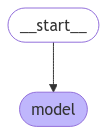

In [28]:
display(Image(app.get_graph().draw_mermaid_png()))

In [16]:
demo_ephemeral_chat_history = [
    HumanMessage(content="Hey there! I'm Nemo."),
    AIMessage(content="Hello!"),
    HumanMessage(content="How are you today?"),
    AIMessage(content="Fine thanks!"),
]

In [18]:
messages = app.invoke(
    {
        "messages": demo_ephemeral_chat_history
        + [HumanMessage("What did I say my name was?")]
    },
    config={"configurable": {"thread_id": "4"}},
)

for message in messages["messages"]:
    message.pretty_print()

================================== Ai Message ==================================

In the conversation, Nemo introduces themselves as Nemo and greets the AI assistant. Nemo then asks the assistant how they are feeling, to which the assistant responds that they are fine.
================================ Human Message =================================

What did I say my name was?
================================== Ai Message ==================================

You introduced yourself as Nemo.


## RAG

In [14]:
docs_path = ('docs') 
pages = []

text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=100)

for filename in os.scandir(docs_path):
    loader = PyPDFLoader(filename.path)
    async for page in loader.alazy_load():
        # split = text_splitter.split_documents(page)
        pages.append(page)
        # splits.append(split)

splits = text_splitter.split_documents(pages)



In [4]:
from IPython.display import HTML, display

tab_pages = ('docs/Dosen_dteti.pdf')

p = []

loader = PyPDFLoader(tab_pages)
async for page in loader.alazy_load():
    p.append(page)

# segments = [
#     doc.metadata
#     for doc in docs
#     if doc.metadata.get("page_number") == 5 and doc.metadata.get("category") == "Table"
# ]

p

[Document(metadata={'source': 'docs/Dosen_dteti.pdf', 'page': 0}, page_content='Dosen \n• 18 Januari 2021, 08.02 \n  \n• Oleh: lilik_suyanti \n  \n• 0 \nStaf Pengajar Departemen Teknik Elektro dan Teknologi Informasi \nStaf Pengajar Departemen Teknik Elektro dan Teknologi Informasi \n \n Prof. Dr. Ir. Sasongko Pramono Hadi, DEA. \n(Guru Besar) \nBidang keilmuan : \nEnergy Conversion, Electrical Power Transmission and Distribution, Power Systems \nhttps://sinta.kemdikbud.go.id/authors/profile/6019394 \n Prof. Ir. P. Insap Santosa, M.Sc., Ph.D., IPU. \n(Guru Besar) \nBidang keilmuan : \nHuman-Computer Interaction (User Experience), Web Application Development, Web \nDesign, IT in Education \nhttps://sinta.kemdikbud.go.id/authors/profile/6010192 \n Ir. Wahyu Dewanto, M.T. \n(Lektor Kepala) \nBidang keilmuan : \nTelecommunication \nhttps://sinta.kemdikbud.go.id/authors/profile/6019805 \n Prof. Ir. Tumiran, M.Eng., Ph.D., IPU. \n(Guru Besar) \nBidang keilmuan : \nEnergy Conversion, Electric

In [7]:
len(pages)

67

In [15]:
# Create the search tools
llm = ChatOpenAI(
    model='gpt-3.5-turbo',
    temperature=0.5,
    max_retries=2,
    max_tokens=500
)

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = InMemoryVectorStore.from_documents(splits, embeddings)

# Index chunks
_ = vector_store.add_documents(documents=splits)


In [46]:
# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")

embed = embeddings.embed_query('apa expertise dari pak ataka?')

docs = vector_store.similarity_search_by_vector(embed, k=2)
for doc in docs:
    print(f'Page {doc.metadata["page"]}: {doc.page_content[:]}\n')

Page 2: Bidang keilmuan : 
Business intelligence and Data analytics 
https://sinta.kemdikbud.go.id/authors/profile/6019179 
 Prof. Ir. Selo, S.T., M.T., M.Sc., Ph.D., IPU, ASEAN Eng. 
(Guru Besar) 
Bidang keilmuan : 
Communication Technology, Software Service Engineering 
https://sinta.kemdikbud.go.id/authors/profile/6010111 
 Prof. Dr.Eng. Ir. F. Danang Wijaya, S.T., M.T., IPM. 
(Guru Besar) 
Bidang keilmuan : 
Electrical Energy Conversion, Power Electronics, Microgrids and Renewable Energy 
Integration 
https://sinta.kemdikbud.go.id/authors/profile/5999249 
 Warsun Najib, S.T., M.Sc. 
(Lektor) 
Bidang keilmuan : 
Computer Network, Mobile & Pervasive computing, Information System, Elearning 
https://sinta.kemdikbud.go.id/authors/profile/6010169 
 Ir. Addin Suwastono, S.T., M.Eng., IPM. 
(Lektor) 
Bidang keilmuan : 
Sistem Instrumentasi Elektronis, Kendali, Elektronika 
https://sinta.kemdikbud.go.id/authors/profile/6019193 
 Prof. Ir. Sarjiya, S.T., M.T., Ph.D., IPU. 
(Guru Besar) 
Bid

In [17]:
docs

[Document(id='54a45284-cd9a-4fe8-920a-6af050577dcf', metadata={'source': 'docs/Dosen_dteti.pdf', 'page': 7}, page_content='HVDC System, Power System Modelling, Renewable Energy Integration, Transmission and \nDistribution, Smart Grid \nhttps://sinta.kemdikbud.go.id/authors/profile/6724608 \n Dzuhri Radityo Utomo, , ST, M.E., Ph.D. \n(Lektor) \nBidang keilmuan : \nRFIC Design, Analog IC Design, Fault Detection and Isolation \nhttps://sinta.kemdikbud.go.id/authors/profile/6724609 \n Syukron Abu Ishaq Alfarozi, S.T., Ph.D \n(Lektor) \nBidang keilmuan : \nIntelligent systems, machine learning, computer vision, signal processing, natural \nlanguage processing \nhttps://sinta.kemdikbud.go.id/authors/profile/6776484 \n Ahmad Ataka Awwalur Rizqi, S.T., Ph.D. \n(Lektor) \nBidang keilmuan : \nIntelligent Robot, Robot Control, Robot Navigation, Robot Learning, Soft Robotics \nhttps://sinta.kemdikbud.go.id/authors/profile/6776475 \n Naufal Hilmi Fauzan, S.Si., M.T. \n(Asisten Ahli) \nBidang keilmu

In [18]:

# class Search(TypedDict):
#     """Search query."""

#     query: Annotated[str, ..., "Search query to run."]
#     section: Annotated[
#         Literal["Dosen_dteti", "Tenaga_Pendidik", "Advisory_Board", "Pengelola"],
#         ...,
#         "Section to query.",
#     ]

# Define state for application
class State(TypedDict):
    question: str
    # query: Search
    context: List[Document]
    answer: str

# Analyze query
# def analyze_query(state: State):
#     structured_query = llm.with_structured_output(Search)
#     query = structured_query.invoke(state["question"])
#     return {"query": query}

# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

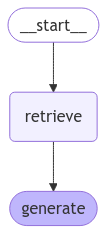

In [48]:
graph

In [47]:
response = graph.invoke({"question": "apa expertise dari pak selo?"})
print(response["answer"])

Pak Selo memiliki keahlian dalam Business Intelligence and Data Analytics.


## RAG Agentic

In [61]:
from langchain_community.document_loaders import WebBaseLoader, PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

# urls = [
#     "https://lilianweng.github.io/posts/2023-06-23-agent/",
#     "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
#     "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
# ]

# os.environ['USER_AGENT'] = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'

docs_path = ('docs')

docs_list = []

for filename in os.scandir(docs_path):
    loader = PyPDFLoader(filename.path)
    async for page in loader.alazy_load():
        # split = text_splitter.split_documents(page)
        docs_list.append(page)
#         # splits.append(split)

# docs = [WebBaseLoader(url).load() for url in urls]
# docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)


In [62]:
len(doc_splits)

168

In [63]:
# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)

retriever = vectorstore.as_retriever()

### Retriever Tool

In [64]:
from langchain.tools.retriever import create_retriever_tool

from langchain_core.tools import BaseTool

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)

retriever = vectorstore.as_retriever()

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_about_dteti",
    "Search and return information about DTETI, lecturers, advisory boards, facility, vision and mission, and it's workers",
)

tools = [retriever_tool]

In [65]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

### Langraph graph

In [66]:
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field

from langgraph.prebuilt import tools_condition

### Edges

def is_translate_to_command(state) -> Literal["translate"]:
    """
    Determines whether the question needs to be translated to move command for robot.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the question needs to be translated
    """

    print("---CHECK TRANSLATE---")

    # Data model
    class translate(BaseModel):
        """Binary score for translation check."""

        binary_score: str = Field(description="Translation score 'translate' or 'not_translate'")

    # LLM
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(translate)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a language translator. \n 
        Here is the user question: {question} \n
        If the question is in a language other than English, translate it to English. \n
        Give a binary score 'translate' or 'not_translate' to indicate whether the question needs to be translated.""",
        input_variables=["question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content

    scored_result = chain.invoke({"question": question})

    score = scored_result.binary_score

    if score == "translate":
        print("---DECISION: TRANSLATE---")
        return "translate"

    else:
        print("---DECISION: NOT TRANSLATE---")
        return "not_translate"


def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"


### Nodes


def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4-turbo")
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)
    response = model.invoke(msg)
    return {"messages": [response]}


def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0, streaming=True)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}


print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Show what the prompt looks like

********************Prompt[rlm/rag-prompt]********************
================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


### Graph

In [67]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()

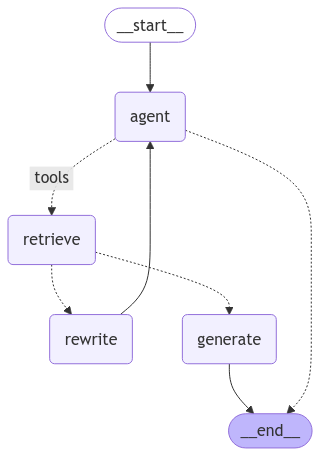

In [68]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [75]:
import pprint

inputs = {
    "messages": [
        ("user", "Do you recall my name?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content="I don't have the ability to recall personal data from previous interactions unless it's shared again in the current session. Please let me know your name!", additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_1a5512f3de'}, id='run-4d582582-e91b-4486-8dce-57e2395d6b4e-0')]}
'\n---\n'


## Agentic RAG with query analysis

In [4]:
### Router
import os

from pydantic import BaseModel, Field

from langchain import hub  

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import PyPDFLoader

from langchain_core.documents import Document
from langchain_core.messages import HumanMessage, SystemMessage, RemoveMessage, AIMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.vectorstores import InMemoryVectorStore

from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph, END
from langgraph.prebuilt import create_react_agent

from IPython.display import Image, display

from typing_extensions import List, TypedDict, Annotated, Literal

from dotenv import load_dotenv

from time import sleep

load_dotenv()

# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "translate_to_command", "web_search", 'agent'] = Field(
        ...,
        description="Given a user question choose to route it to web search, robot command translation, or a vectorstore. If no match route to agent",
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
system = """You are an expert at routing a user query to a vectorstore or web search or robot command translation tools .
The vectorstore contains documents related to DTETI lecturer, vision and mission, and its advisory boards.
Use the vectorstore for questions on these topics. Otherwise, use web-search.
Use robot command translation tool when provided query is related to navigation.
Route to agent if the query is not related to any of the above.
"""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router
print(
    question_router.invoke(
        {"question": "Halo"}
    )
)
print(question_router.invoke({"question": "Bisa minta tolong arahin ke ruang dosen?"}))

datasource='agent'
datasource='translate_to_command'


In [5]:
# Retriever
from langchain_community.document_loaders import WebBaseLoader, PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.tools import create_retriever_tool

# urls = [
#     "https://lilianweng.github.io/posts/2023-06-23-agent/",
#     "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
#     "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
# ]

# os.environ['USER_AGENT'] = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'

docs_path = ('docs')

docs_list = []

for filename in os.scandir(docs_path):
    loader = PyPDFLoader(filename.path)
    async for page in loader.alazy_load():
        # split = text_splitter.split_documents(page)
        docs_list.append(page)
#         # splits.append(split)

# docs = [WebBaseLoader(url).load() for url in urls]
# docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)


# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)

retriever = vectorstore.as_retriever()

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_about_dteti",
    "Search and return information about DTETI, lecturers, advisory boards, facility, vision and mission, and it's workers",
)

tools = [retriever_tool]


USER_AGENT environment variable not set, consider setting it to identify your requests.


In [6]:
# Translate to command Model
from typing import Optional

class CommandParameters(TypedDict):
    """
    CommandParameters model to represent the parameters of a command.
    """
    target: Annotated[Optional[Literal['lecturer_room', 'lab_ai', 'coworking_space']], None, "The target of place of the command, using variable naming style."]
    context: Annotated[Optional[str], None, "The context of the command."]
    # intent: Annotated[Optional[str], ..., "The intent explanation of the command."]

class Command(TypedDict):
    """
    Command model to represent a command.
    """
    isNav: Annotated[bool, ..., "Is the command a navigation command?"]
    parameters: Annotated[CommandParameters, ..., "The parameters of the command."]

class Translation(TypedDict):
    """
    Translation model to represent a translation.
    Attributes:
        text (str): The translated text.
        source_language (str): The source language of the text.
        target_language (str): The target language of the text.
    """
    source_language: Annotated[str, ...,"The source language of the text."]
    command: Annotated[Command, ..., "The command to be executed."]
    confidence: Annotated[float, ..., "The confidence value 0 - 1.0 of the translation into command for robot."]


In [7]:
# Retrieval Grader

class GradeDocuments(BaseModel):
    """Binary Score relevance check for documents retrieved"""

    binary_score: str = Field(description="Documents are relevant to the query,'yes' or 'no'")

# LLM with func calls
llm = ChatOpenAI(model='gpt-3.5-turbo-0125', temperature=0)
structured_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
"""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_grader
question = "sebutkan visi-misi prodi teknik elektro"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))


binary_score='yes'


In [8]:
# Generate
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

prompt = hub.pull('rlm/rag-prompt')

# llm

llm = ChatOpenAI(model='gpt-3.5-turbo', temperature=0)

# Post processing
def format_docs(docs):
    return '\n\n'.join(doc.pagecontent for doc in docs)

# Chain 
rag_chain = prompt | llm | StrOutputParser()

# Run
generate = rag_chain.invoke({'context': docs, 'question':question})
print(generate)


Visi Prodi Teknik Elektro adalah menjadi sumber inovasi yang universal di bidang ilmu Teknik Elektro untuk kepentingan bangsa dan kemanusiaan. Misi program tersebut adalah menghasilkan lulusan yang memiliki kompetensi tinggi, berkarakter, dan berintegritas serta mengembangkan penelitian yang berkontribusi pada pengembangan keilmuan di bidang Teknik Elektro.


In [9]:
# Answer grader

class GradeAnswer(BaseModel):
    """Binary score to grade answer relevance, 'yes' or 'no'"""
    binary_score:str = Field(description='Answer related to the question, "yes" or "no"')

# llm
llm = ChatOpenAI(model='gpt-3.5-turbo-0125', temperature=0)
structured_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing relevance of an answer to a user question. \n 
    If the answer contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the answer is relevant to the question.
"""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: {question} \n\n LLM Answer: {answer} \n"),
    ]
)

answer_grader = grade_prompt | structured_grader
answer_grader.invoke({"question": question, "answer": generate})


GradeAnswer(binary_score='yes')

In [10]:
# Query rewriter

llm = ChatOpenAI(model='gpt-3.5-turbo-0125', temperature=0)

# Prompt
system = """You are a query/question rewriter that converts an input into a better optimized version. \n 
    Given the query/question, improve it to be better for vectorstore search. Please look into its underlying semantic meanings or its intent.\n
    Here is the user question: {question} \n
"""

rewrite_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Initial question: {question} \n\n Improved question: "),
    ]
)

rewrite_chain = rewrite_prompt | llm | StrOutputParser()
print(rewrite_chain.invoke({"question": "sebutkan visi-misi prodi teknik elektro di DTETI?"}))

What are the vision and mission of the Electrical Engineering program at DTETI?


In [11]:
retrieval_grader

ChatPromptTemplate(input_variables=['document', 'question'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template="You are a grader assessing relevance of a retrieved document to a user question. \n \n    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n\n    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n\n    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.\n"), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['document', 'question'], input_types={}, partial_variables={}, template='Retrieved document: \n\n {document} \n\n User question: {question}'), additional_kwargs={})])
| RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x147e5b

In [12]:
# Web Search Tools

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

In [13]:
web_search_tool.invoke("Apa gelar lengkap dari pak ahmad ataka?")

[{'url': 'https://ahmadataka.bitbucket.io/',
  'content': 'Honors & Awards. 2 nd Winner of The Queen Mary UK PhD in Robotics Award 2019 The award is granted to best candidates who finished their Ph.D. in the field of robotics in the UK in 2019. 1 st Place in National Final Microsoft Imagine Cup 2016 World Citizenship Imagine Cup is an international innovation competition held annually by Microsoft for university student.'},
 {'url': 'https://alif.id/read/author/atk/',
  'content': "Dari Kuliner Nusantara hingga Bazar Buku akan Hadir di Pasar Bestari Festival Beda Setara. Kemenbud Harus Bekerjasama dengan Banyak Pemangku Kepentingan. ... Ahmad Ataka. Ahmad Ataka lahir di Banyuwangi 24 Juli 1992. Ia menyelesaikan S3 di bidang Robotika di King's College London. Bersama satu istri dan satu anak, Ataka tinggal di London"},
 {'url': 'https://nu.or.id/nasional/ahmad-ataka-nahdliyin-doktor-muda-ahli-robotik-lulusan-inggris-KlLXW',
  'content': "Tidak mudah bagi Ahmad Ataka Awwalur Rizqi menjal

### Graph Making

In [14]:
# Graph state

from typing import TypedDict, List

class GraphState(TypedDict):
    """
    GraphState is a TypedDict that represents the state of a graph.
    Attributes:
        question (str): A question provided by the user.
        generated (str): A string indicating the generated LLM string.
        document (List[str]): A list of strings representing the document retrieved.
        retries (int): An integer representing the number of retries.
    """
    question: str
    generated: str
    documents: List[str]
    retries: int = 0

In [29]:
## Graph Flow

from langchain.schema import Document

# Agent

def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["question"]
    model = ChatOpenAI(temperature=0, model="gpt-4-turbo") | StrOutputParser()
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"generated": [response]}

def retrieve(state):
    """
    Retrieve relevant documents from the vectorstore.

    Args:
        state (GraphState): The current state

    Returns:
        dict: The updated state with the retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]
    retry = state["retries"]
    print("RETRY:", retry)
    docs = retriever.invoke(question)
    return {"documents": [doc.page_content for doc in docs]}

def generate(state):
    """
    Generate an answer based on the retrieved documents.

    Args:
        state (GraphState): The current state

    Returns:
        dict: The updated state with the generated answer
    """
    print("---GENERATE---")
    question = state["question"]
    docs = state["documents"]
    # RAG chain
    result = rag_chain.invoke({'context': docs, 'question': question})
    return {"question": question , "document": docs, "generated": result}

def grade_docs(state):
    """
    Grade the relevance of the retrieved documents.

    Args:
        state (GraphState): The current state

    Returns:
        dict: The updated state with the graded relevance
    """
    print("---GRADE---")
    question = state["question"]
    docs = state["documents"]

    filtered_docs = []
    # Score each docs
    for d in docs:
        doc_txt = d
        score = retrieval_grader.invoke({"question": question, "document": doc_txt})
        if score.binary_score == "yes":
            print('---DOC RELEVANT---')
            filtered_docs.append(d)
        else:
            print('---DOC NOT RELEVANT---')
            continue
    return {"documents": filtered_docs, "question": question}

def rewrite_query(state):
    """
    Rewrite the user query to be more optimized for the vectorstore search.

    Args:
        state (GraphState): The current state

    Returns:
        dict: The updated state with the rewritten query
    """
    print("---REWRITE---")
    question = state["question"]
    
    result = rewrite_chain.invoke({"question": question})
    return {"question": result, "retries": state["retries"] + 1}

def translate_to_command(state):
    """
    Translate the user query to a robot command.

    Args:
        state (GraphState): The current state

    Returns:
        dict: The updated state with the translated command
    """
    print("---TRANSLATE---")
    question = state["question"]
    result = llm.with_structured_output(Translation).invoke(question)
    return {"generated": result, "question": question}

def web_search(state):
    """
    Perform a web search for the user query.

    Args:
        state (GraphState): The current state

    Returns:
        dict: The updated state with the web search results
    """
    print("---WEB SEARCH---")
    question = state["question"]
    try :
        docs = web_search_tool.invoke({"query": question})
        web_res = '\n\n'.join([d['content'] for d in docs])
        web_res = Document(page_content=web_res)
    except Exception as e:
        print(e)
        web_res = "Error: Web search failed please try in a moment."
        web_res = Document(page_content=web_res)

    return {"question": question, "documents": web_res}

In [25]:
## Edges ##

def route_question(state):
    """
    Route the user question to the most relevant datasource.

    Args:
        state (GraphState): The current state

    Returns:
        str: The datasource to route the question to
    """
    print("---ROUTE---")
    print("--STATE--", state)
    question = state["question"]
    result = question_router.invoke({"question": question})
    if result.datasource == 'vectorstore':
        print('---VECTORSTORE---')
        return 'vectorstore'
    elif result.datasource == 'translate_to_command':
        print('---TRANSLATE---')
        return 'translate_to_command'
    elif result.datasource == 'web_search':
        print('---WEB SEARCH---')
        return 'web_search'
    else:
        return 'agent'
    
def decide_to_generate(state):
    """
    Decide whether to generate an answer based on the relevance of the documents.

    Args:
        state (GraphState): The current state

    Returns:
        str: The decision to generate or not
    """
    print("---DECIDING TO GENERATE---")
    docs = state["documents"]
    if state["retries"] >= 2:
        print('---RETRIES EXCEEDED WEB SEARCH WILL BE USED---')
        return 'web_search'
    if len(docs) > 0:
        print('---RESULT: GENERATE---')
        return 'generate'
    else:
        print('---RESULT: REWRITE---')
        return 'rewrite_query'

In [30]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("translate_to_command", translate_to_command)  # translate to command
workflow.add_node("grade_docs", grade_docs)  # grade documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("rewrite_query", rewrite_query)  # rewrite query
workflow.add_node("agent", agent)  # agent

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
        "translate_to_command": "translate_to_command",
        'agent': 'agent'
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_docs")
workflow.add_conditional_edges(
    "grade_docs",
    decide_to_generate,
    {
        "rewrite_query": "rewrite_query",
        "generate": "generate",
        "web_search": "web_search",
    },
)
workflow.add_edge("rewrite_query", "retrieve")
workflow.add_edge("generate", END)
workflow.add_edge("translate_to_command", END)
workflow.add_edge("agent", END)

# Compile
app = workflow.compile()

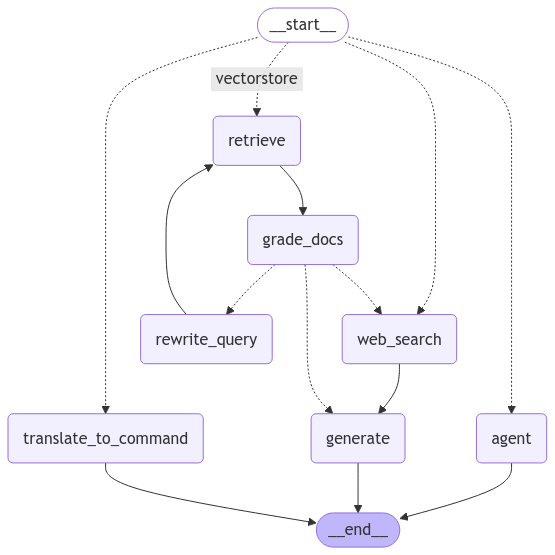

In [31]:
app

In [32]:
from pprint import pprint

# Run
inputs = {
    "question": "Halo selamat siang",
    "retries": 0
}

for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")


---ROUTE---
--STATE-- {'question': 'Halo selamat siang', 'retries': 0}
---CALL AGENT---
"Node 'agent':"
'\n---\n'


In [34]:
# Final generation
app.invoke(inputs)

---ROUTE---
--STATE-- {'question': 'Halo selamat siang', 'retries': 0}
---CALL AGENT---


{'question': 'Halo selamat siang',
 'generated': ['Selamat siang! Ada yang bisa saya bantu?'],
 'retries': 0}